# SIIM-ACR Pneumothorax Segmentation
# Identify Pneumothorax disease in chest x-rays
# Dijon Michael
# Perret Xavier
# M1 IPS

# Qu'est-ce qu'un pneumothorax ?
Un pneumothorax correspond au remplissage d'air ou de gaz dans l'espace pleural. Cette poche d'air se retrouve alors entre la face interne de la cage thoracique et la face externe du poumon. Il peut-être spontané ou survenir après une pathologie et peut être fatal dans certains cas. Les symptômes sont la gêne respiratoire, toux, douleurs throaciques et angoisse. Si il n'est pas traité rapidement, il peut y avoir des complications. Le but de ce challenge est de déterminer les personnes les plus à risques en classifiant les radiographies présentant un pneumothorax.

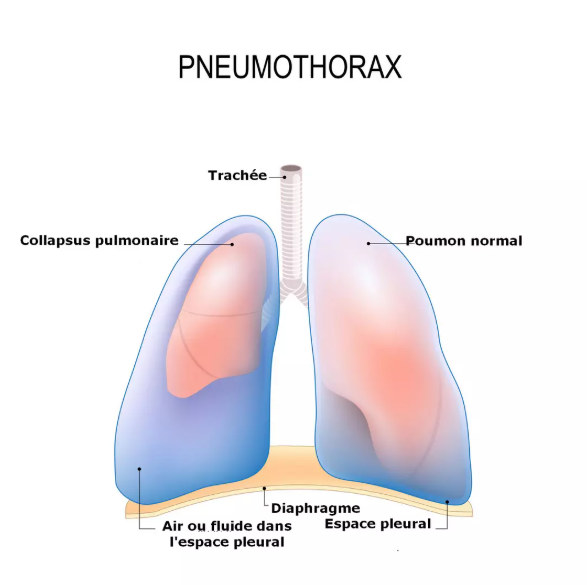

# Fichiers nécessaires à la segmentation

• train-rle.csv permet de référencer les images présentant ou non un pneumothorax. Ce fichier contient deux colonnes, 'ImageId'   qui est la référence de l'image et 'EncodedPixels' qui est une annotation/indicateur. Si une radio ne présente pas de pneumothorax, alors 'EncodedPixels' = -1

• dicom-images-train est un ensemble d'image radiograpique à des fins de formation, c'est-à-dire que nous connaissons les pneumothorax présent dans ce dossier. Si le programme marche sur ce dossier alors il est censé marcher pour les tests.

• dicom-images-test est un ensemble d'image radiographique à tester. C'est-à-dire que nous ne savons pas lesquels présentes des pneumothorax mais nous allons essayer de le prédire grâce à dicom-images-train. Car si un cas est similaire dans dicom-images-train et dans dicom-images-test, alors on pourra prédire le résultat du test.

• mask_functions qui est la fonction de marquage des pneumothoraxs.

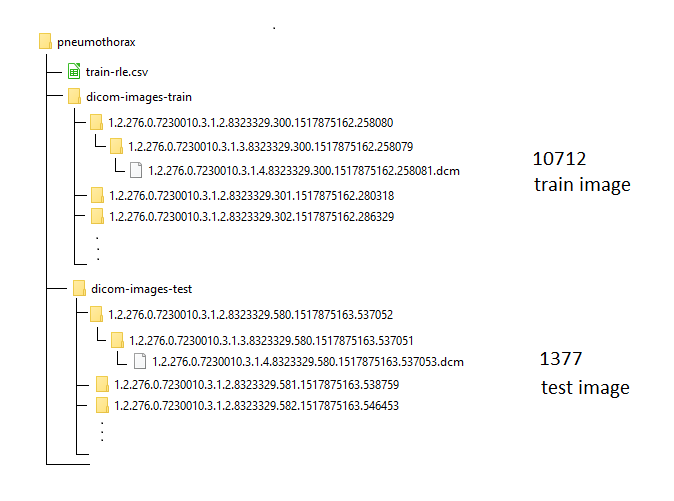
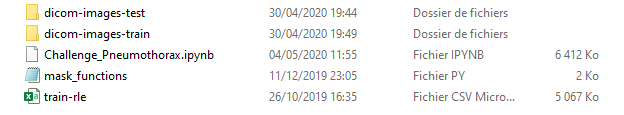

# But du challenge

Devant un patient dyspnéique sans raison apparente, il faut savoir s'il s'agit d'un pneumothorax pour le prendre en charge rapidement. Le but de ce challenge est de réaliser une analyse automatisée de radiographies thoraciques pour rechercher un pneumothorax. 

Le pneumothorax est généralement diagnostiqué par un radiologue sur une radiographie pulmonaire et peut parfois être très difficile à confirmer. Pour classer les radiographies thoraciques, réaliser une interprétation prioritaire et fournir aux autres praticiens (n'étant pas radiologue) un diagnostic, il faut faire un programme permettant de classer les radiographies par ordre de gravité.

Pour cela, nous avons un fichier training sur lequel nous segmenterons les pneumothoraxes pour 'entraîner' notre programme de classification qui devra agir sur les images test (dont nous ne connaissons pas le diagnostic).

La Society for Imaging Informatics in Medicine (SIIM) est le principal organisme de soins de santé pour les personnes intéressées par l'utilisation actuelle et future de l'informatique en imagerie médicale. Leur mission est de faire progresser l'informatique d'imagerie médicale à travers l'entreprise grâce à l'éducation, la recherche et l'innovation dans une communauté multidisciplinaire.

Dans ce concours, on va développer un modèle pour classer (et s'il est présent, segmenter) le pneumothorax à partir d'un ensemble d'images radiographiques thoraciques dans le but de contribuer à la reconnaissance précoce des pneumothoraxes et sauver des vies.

# Partie segmentation

# Bibliothèques

In [2]:
# Nécessaire pour des calculs numériques
import numpy as np
from numpy import arange

# Nécessaire pour la manipulation de données des images DICOM
import pandas as pd

# Nécessaire pour tracer des graphes et afficher des images
import matplotlib.pyplot as plt
from matplotlib import patches as patches
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Nécessaire à la manipulation d'images
import cv2

# Nécessaire pour charger les données des images Dicom
import pydicom

# Nécessaire pour parcourir et charger les images d'un dossier
from glob import glob

# Nécessaire pour faire apparaître un indicateur de progression lors du chargement des images DICOM
from tqdm import tqdm

#Nécessaire pour le machine learning
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate
from sklearn.model_selection import train_test_split


# Fonction du masque

In [3]:
# Pour simplifier le code sur Jupyter et pour avoir une meilleur visibilité, nous avons préféré copier la fonction
# du masque plutôt que de l'importer

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)


# Lecture du fichier train-rle.csv

In [4]:
# Lecture du fichier csv grâce à pd.read_csv
rles_df = pd.read_csv('C:/Users/michael/Desktop/Challenge Image/pneumothorax/train-rle.csv')

# On donne un nom pour identifier les colonnes du fichier .csv
rles_df.columns = ['ImageId', 'EncodedPixels']

# Définiton pour extraire les données des images DICOM

In [5]:
def dicom_to_dict(dicom_data, file_path, rles_df, encoded_pixels=True):
    
    # Analyse des metadonnées des fichiers DICOM et les retourne dans un dictionnaire nommé data
    # dicom_data : données de la radiographie au format DICOM.
    # file_path : chemin du fichier DICOM
    
    data = {}
    
    # On cherche les données suivantes dans les metadonnées
    data['patient_name'] = dicom_data.PatientName
    data['patient_id'] = dicom_data.PatientID
    data['patient_age'] = int(dicom_data.PatientAge)
    data['patient_sex'] = dicom_data.PatientSex
    data['pixel_spacing'] = dicom_data.PixelSpacing
    data['file_path'] = file_path
    data['id'] = dicom_data.SOPInstanceUID
    data['modality'] = dicom_data.Modality
    data['bodypart'] = dicom_data.BodyPartExamined
    data['viewposition'] = dicom_data.ViewPosition
    data['EncodedPixels'] = encoded_pixels
    
    # encoded_pixels (bool): Si il est True, alors on recherche l'annotation dans encoded_pixels_list pour voir
    # si il y a un pneumothorax.
    if encoded_pixels: 
        
        # On crée une liste contenant toutes les 'encoded_pixels' et les Id des images auxquelles elles correspondent
        # dans le fichier .csv
        encoded_pixels_list = rles_df[rles_df['ImageId']==dicom_data.SOPInstanceUID]['EncodedPixels'].values 
        
        # Il n'y a pas de pneumothorax si il y a une annotation (-1)
        pneumothorax = False
        
        # Ensuite on parcours la liste pour voir les 'encoded_pixels' != -1 (valeur du masque != -1)
        for encoded_pixels in encoded_pixels_list:
            if encoded_pixels != ' -1': # L'annotation est -1
                pneumothorax = True
        
        # On extrait les informations suivantes pour voir la longueur de la liste et comptabiliser les personnes ayant
        # un pneumothorax
        data['encoded_pixels_list'] = encoded_pixels_list
        data['has_pneumothorax'] = pneumothorax
        data['encoded_pixels_count'] = len(encoded_pixels_list)
        
    return data
    return encoded_pixels_list


# Création d'une liste avec tous les fichiers training

In [6]:
# Création d'une liste avec toutes les images .dcm de dicom_images_train
train_fns = sorted(glob('C:/Users/michael/Desktop/Challenge Image/pneumothorax/dicom-images-train/*/*/*.dcm'))
train_metadata_df = pd.DataFrame()
train_metadata_list = []
for file_path in tqdm(train_fns): # On parcours toutes les images de dicom-images-train
    # On lit les métadonnées de chaques fichiers dicom et on retourne un dictionnaire contenant ces informations
    dicom_data = pydicom.dcmread(file_path)
    train_metadata = dicom_to_dict(dicom_data, file_path, rles_df)
    train_metadata_list.append(train_metadata)
train_metadata_df = pd.DataFrame(train_metadata_list) # Permet de créer des séries de données pour chaque image

100%|████████████████████████████████████████████████████████████████████████████| 10712/10712 [06:26<00:00, 27.69it/s]


# Création d'une liste avec tous les fichiers tests

In [7]:
# Création d'une liste avec toute les images .dcm de dicom_images_train
test_fns = sorted(glob('C:/Users/michael/Desktop/Challenge Image/pneumothorax/dicom-images-test/*/*/*.dcm'))
test_metadata_df = pd.DataFrame()
test_metadata_list = []
for file_path in tqdm(test_fns): # On parcours toutes les images de dicom-images-test
    # On lit les métadonnées de chaque fichier dicom et on retourne un dictionnaire contenant ces informations
    dicom_data = pydicom.dcmread(file_path)
    test_metadata = dicom_to_dict(dicom_data, file_path, rles_df, encoded_pixels=False)
    test_metadata_list.append(test_metadata)
test_metadata_df = pd.DataFrame(test_metadata_list) # Permet de créer des séries de données pour chaque image

100%|██████████████████████████████████████████████████████████████████████████████| 1377/1377 [00:33<00:00, 40.73it/s]


Chaque image DICOM possède des métadonnées permettant d'identifier le patient

# Affichage de l'image et de ses métadonnées

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.7052.1517875202.524577
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '70c5b971-13fd-4600-b0af-9d6f02dc4342'
(0010, 0020) Patient ID                          LO: '70c5b971-13fd-4600-b0af-9d6f02dc4342'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's

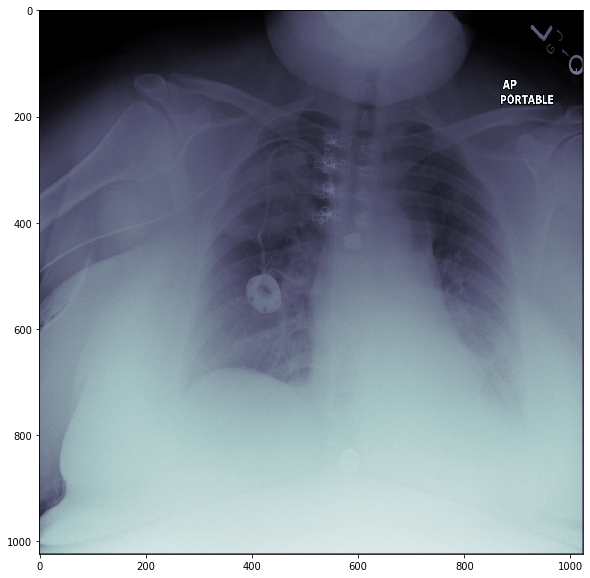

In [8]:
# Définition pour l'affichage de toute les métadonnées présentes dans les images DICOM
def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dicom_data.pixel_array, cmap=plt.cm.bone)
    plt.show()

for file_path in sorted(glob('C:/Users/michael/Desktop/Challenge Image/pneumothorax/dicom-images-train/*/*/*.dcm')):
    dataset = pydicom.dcmread(file_path) # Extraction des métadonnées d'une image DICOM (file_path)
    print(dicom_data) # On affiche les métadonnées
    plot_pixel_array(dataset) # On affiche l'image correspondante
    break # On affiche qu'une seule image car il y en a beaucoup trop. Si on veut voir toutes les métadonnées et toutes 
    # les images alors il faut mettre en commentaire le break

# Proportion de femmes et d'hommes dans l'échantillon

In [9]:
# On parcours toutes images DICOM et on compte celles appartenants à des femmes et celles appartenants à des hommes
Feminin = 0
Masculin = 0
for file_path in tqdm(sorted(glob('C:/Users/michael/Desktop/Challenge Image/pneumothorax/dicom-images-train/*/*/*.dcm'))):
    dataset = pydicom.dcmread(file_path)
    #print(dicom_data)
    #plot_pixel_array(dataset)
    if dataset.PatientSex == 'F':
        Feminin = Feminin + 1
    else :
        Masculin = Masculin + 1
print ("Il y a", Feminin, "femmes et",Masculin,"hommes" )

100%|████████████████████████████████████████████████████████████████████████████| 10712/10712 [04:13<00:00, 42.33it/s]

Il y a 4809 femmes et 5903 hommes


# Diagrammes des répartitions

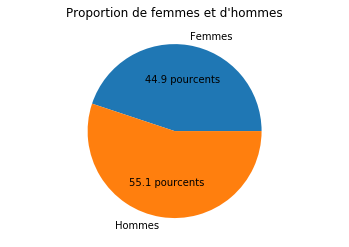

In [10]:
fig, ax = plt.subplots()
ax.axis("equal")
ax.pie([Feminin, Masculin], labels = ["Femmes", "Hommes"], autopct="%1.1f pourcents")
plt.title("Proportion de femmes et d'hommes")
plt.show()



# Affichage des images training DICOM avec et sans pneumothorax

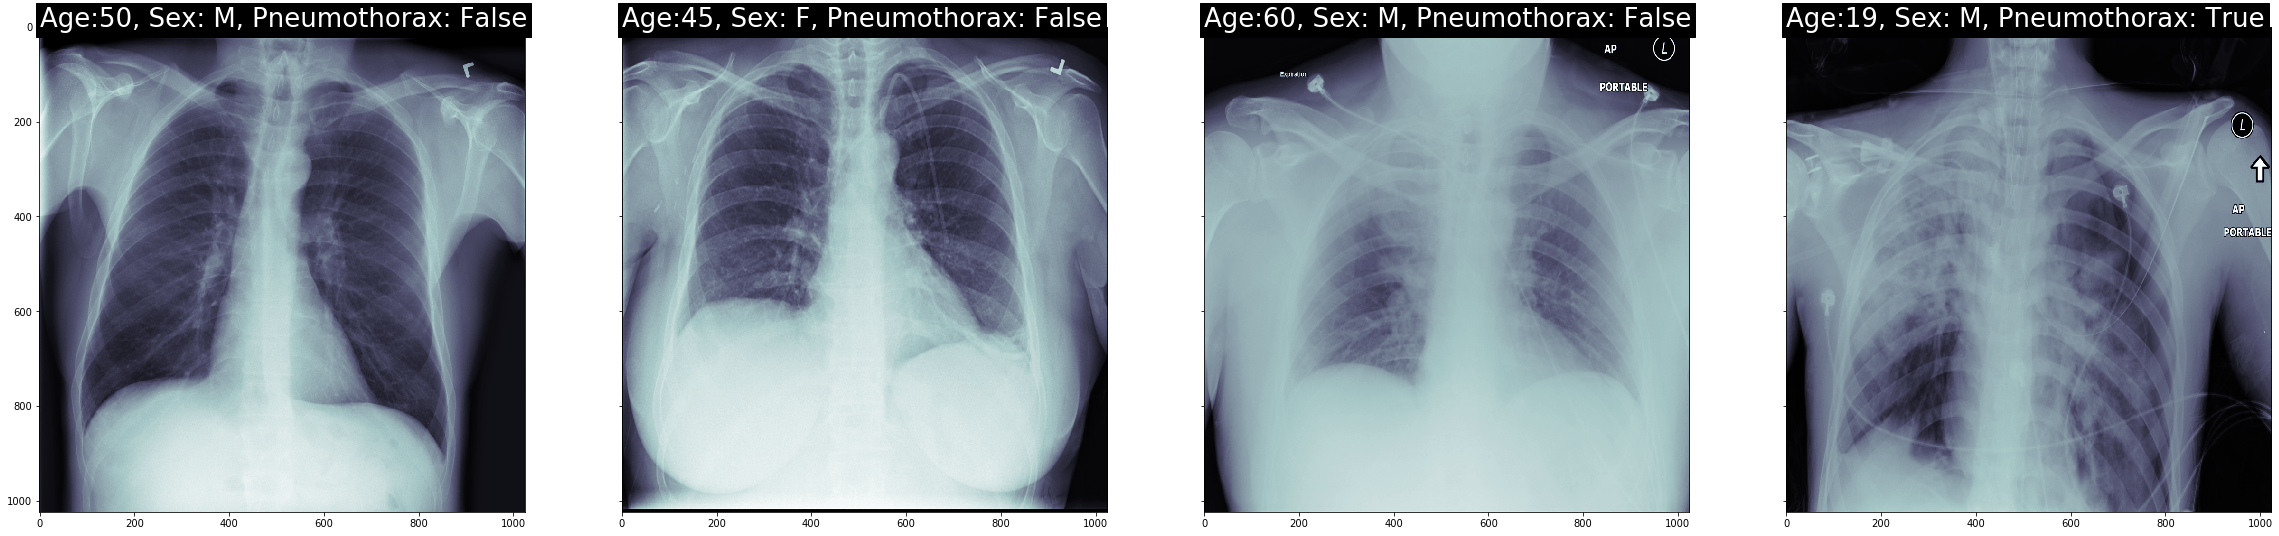

In [11]:
num_img = 4 # On affiche 4 images
subplot_count = 0
fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for index, row in train_metadata_df.sample(n=num_img).iterrows():
    dataset = pydicom.dcmread(row['file_path'])
    ax[subplot_count].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    # On charge et on affiche l'image avec l'âge, le sexe et si il y a présence d'un pneumothorax
    ax[subplot_count].text(0,0,'Age:{}, Sex: {}, Pneumothorax: {}'.format(row['patient_age'],row['patient_sex'],row['has_pneumothorax']),
                           size=26,color='white', backgroundcolor='black')
    subplot_count += 1

# Définition du rectangle autour de la zone de pneumothorax

In [12]:
# Cette définition donne les dimensions des rectangles qui seront tracés autour des pneumothorax grâce aux annotations
# du masque
def bounding_box(img):
    # Retourne les dimensions du rectangle
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

# Affichage des images avec et sans masques

In [13]:
def plot_with_mask_and_bbox(file_path, mask_encoded_list, figsize=(20,10)):
    
        # file_path (str): Chemin du fichier DICOM
        # mask_encoded (numpy.ndarray): Pandas dataframe of the RLE.
        
        # Retourne les images DICOM avec et sans masques
    
    pixel_array = pydicom.dcmread(file_path).pixel_array
    
    # On fait une egalisation d'histogramme pour améliorer le contraste de chaque image et rendre les pneumothorax plus 
    # visible 
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
    clahe_pixel_array = clahe.apply(pixel_array)
    
    # On utilise le masque sur chaque images
    mask_decoded_list = [rle2mask(mask_encoded, 1024, 1024).T for mask_encoded in mask_encoded_list]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,10))
    
    # On affiche l'image original avec son masque et le pneumothorax localiser dans un carré grâce à la zone annoté par le 
    # masque
    ax[0].imshow(pixel_array, cmap=plt.cm.bone)
    for mask_decoded in mask_decoded_list:
        ax[0].imshow(mask_decoded, alpha=0.3, cmap="Reds")
        rmin, rmax, cmin, cmax = bounding_box(mask_decoded)
        bbox = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1,edgecolor='r',facecolor='none')
        ax[0].add_patch(bbox)
    ax[0].set_title('Avec masque')
    
    # On affiche les images avec un meilleur contraste et sans masque
    # On utilise la méthode CLAHE (Contrast Limites Adaptative Histogramm Equalization)
    ax[1].imshow(clahe_pixel_array, cmap=plt.cm.bone)
    for mask_decoded in mask_decoded_list:
        rmin, rmax, cmin, cmax = bounding_box(mask_decoded)
        bbox = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1,edgecolor='r',facecolor='none')
        ax[1].add_patch(bbox)
    ax[1].set_title('Sans masque mais avec égalisation d''histogramme')
    
    # On affiche l'image original avec le pneumothorax dans un rectangle
    ax[2].imshow(pixel_array, cmap=plt.cm.bone)
    for mask_decoded in mask_decoded_list:
        rmin, rmax, cmin, cmax = bounding_box(mask_decoded)
        bbox = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1,edgecolor='r',facecolor='none')
        ax[2].add_patch(bbox)
    ax[2].set_title('Sans masque')
    plt.show()

# Affiche 5 images au hasard

image id: 1.2.276.0.7230010.3.1.4.8323329.14018.1517875249.164341


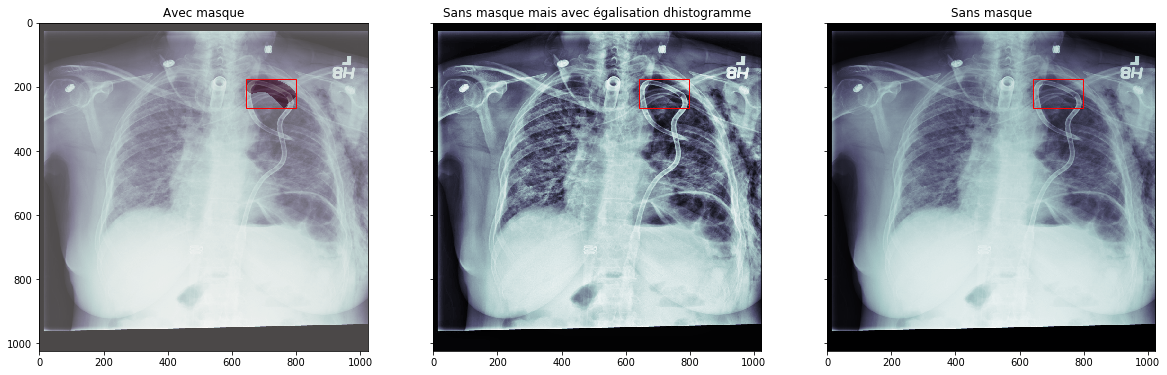

image id: 1.2.276.0.7230010.3.1.4.8323329.32203.1517875158.998670


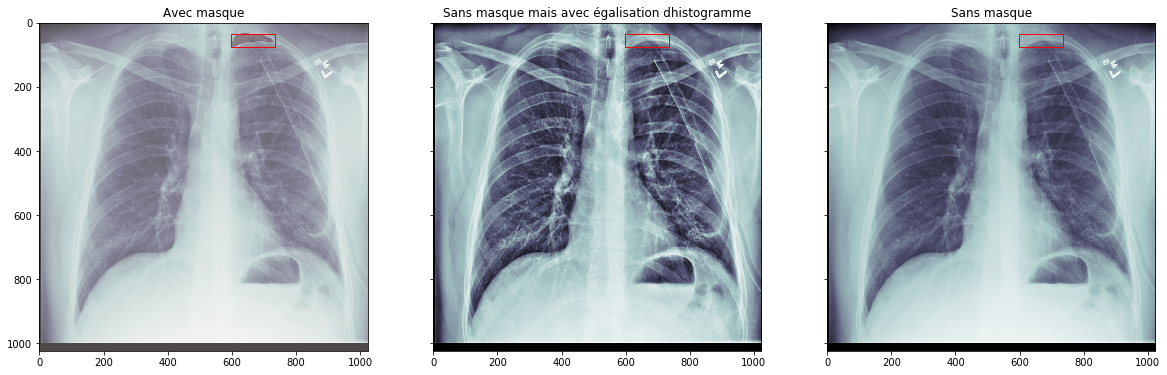

image id: 1.2.276.0.7230010.3.1.4.8323329.4333.1517875182.329762


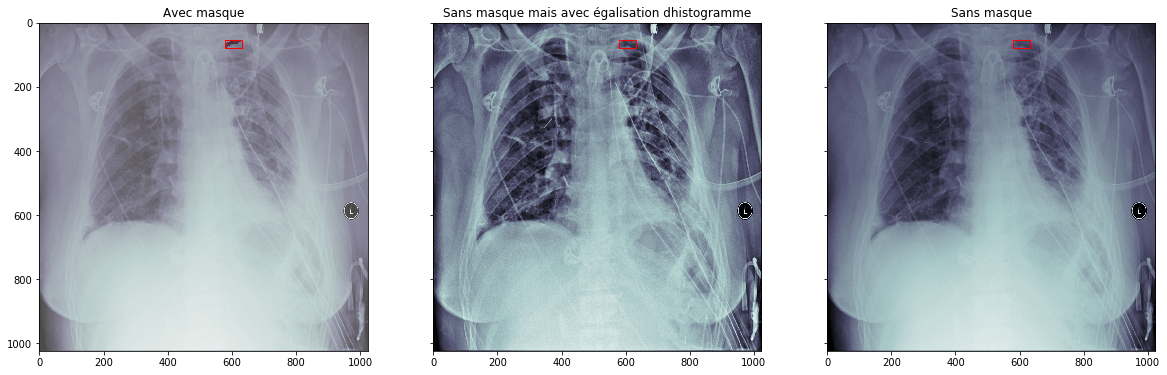

image id: 1.2.276.0.7230010.3.1.4.8323329.12225.1517875238.56611


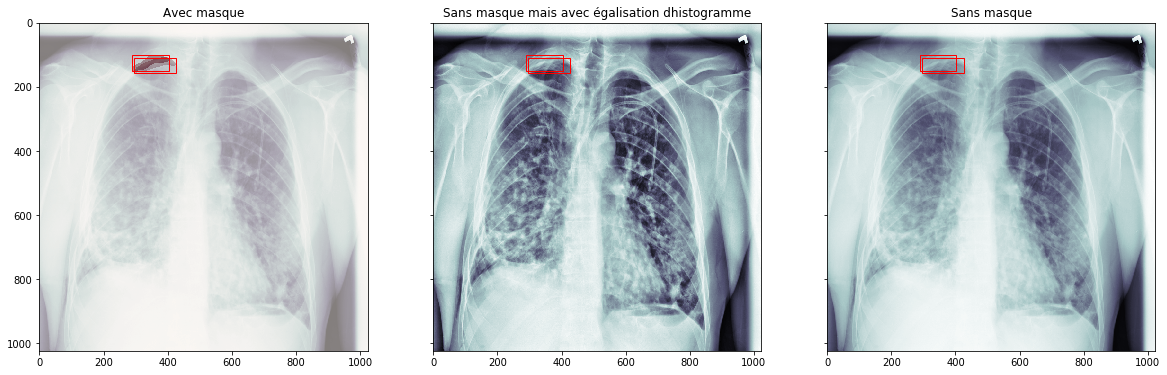

image id: 1.2.276.0.7230010.3.1.4.8323329.4719.1517875184.295708


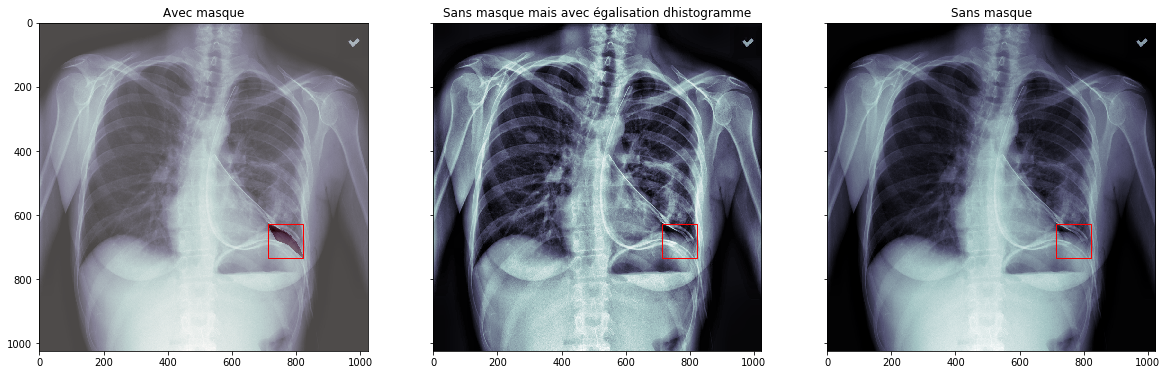

In [14]:
# On choisit 5 images au hasard pour appliquer l'égalisation d'histogramme et le masque
train_metadata_sample = train_metadata_df[train_metadata_df['has_pneumothorax']==1].sample(n=5)

# On affiche ces images
for index, row in train_metadata_sample.iterrows():
    file_path = row['file_path']
    mask_encoded_list = row['encoded_pixels_list']
    print('image id: ' + row['id'])
    plot_with_mask_and_bbox(file_path, mask_encoded_list)

# Histogramme de la répartition des pneumothorax en fonction de l'âge et du genre

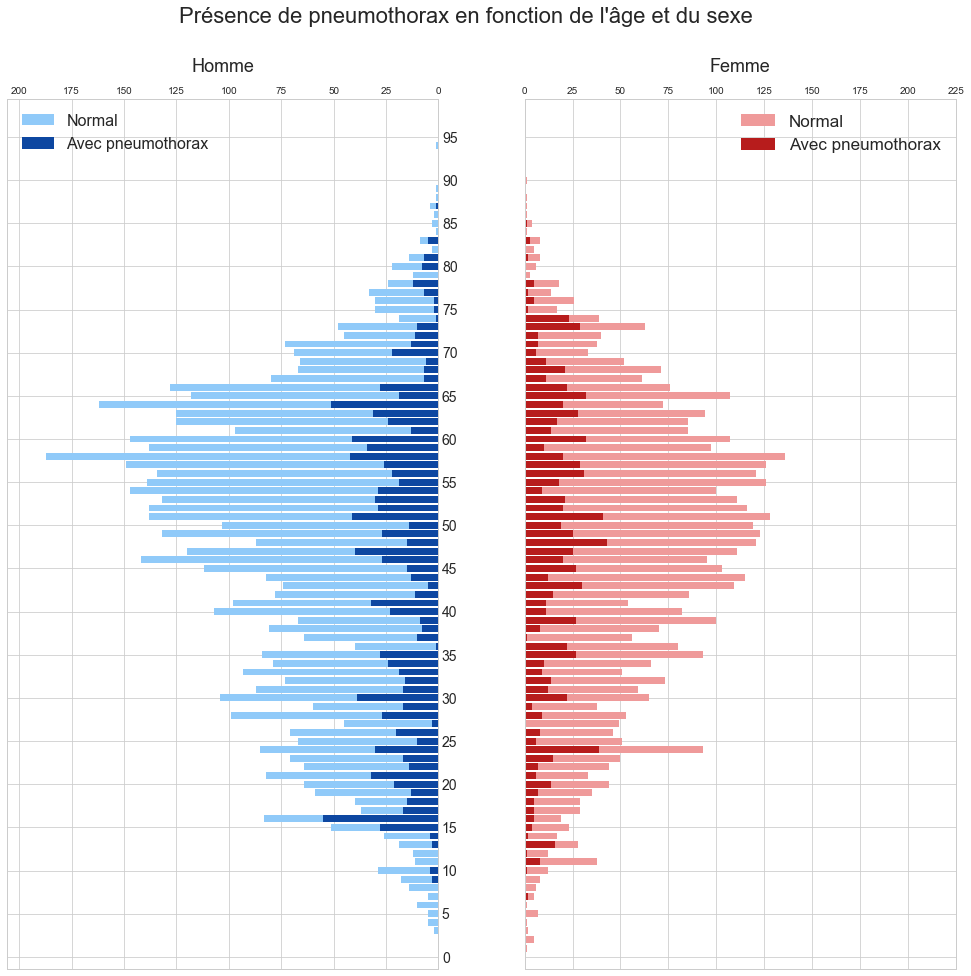

In [15]:
#Le but de cette partie du programme est d'afficher un histogramme avec le nombre de femme et d'homme ayant un pneumothorax
# en fonction de leur âge

patients = [] # On créer une liste vide qui prendra les métadonnées de chaque image
missing = 0

for file_path in sorted(glob('C:/Users/michael/Desktop/Challenge Image/pneumothorax/dicom-images-train/*/*/*.dcm')):
    data1 = pydicom.dcmread(file_path)
    test = dicom_to_dict(data1, file_path, rles_df, encoded_pixels=True)
    missing = missing + 1
    patients.append(test)
    
df_patients = pd.DataFrame(patients, columns=["id", "has_pneumothorax", "patient_age", "patient_sex", "modality", "bodypart", "viewposition"])

bins = [i for i in range(100)]
plt.style.use('seaborn-whitegrid')

# En premier, on fait l'histogramme de la repartition de femme et d'homme en fonction de leur âge
all_men = np.histogram(df_patients[df_patients["patient_sex"] == "M"]["patient_age"].values, bins=bins)[0]
all_women = np.histogram(df_patients[df_patients["patient_sex"] == "F"]["patient_age"].values, bins=bins)[0]

# En second, on fait l'histogramme des personnes ayant un pneumothorax en fonction de leur âge et de leur genre
ill_men = np.histogram(df_patients[(df_patients["patient_sex"] == "M") & (df_patients["has_pneumothorax"] == True)]["patient_age"].values, bins=bins)[0]
ill_women = np.histogram(df_patients[(df_patients["patient_sex"] == "F") & (df_patients["has_pneumothorax"] == True)]["patient_age"].values, bins=bins)[0]

# On trace les histogrammes
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(17, 16))

fig.suptitle("Présence de pneumothorax en fonction de l'âge et du sexe", fontsize=22, y=0.96)

axes[0].margins(x=0.1, y=0.01)
m1 = axes[0].barh(bins[:-1], all_men, color='#90CAF9')
m2 = axes[0].barh(bins[:-1], ill_men, color='#0D47A1')
axes[0].set_title('Homme', fontsize=18, pad=15)
axes[0].invert_xaxis()
axes[0].set(yticks=[i*5 for i in range(20)])
axes[0].tick_params(axis="y", labelsize=14)
axes[0].yaxis.tick_right()
axes[0].xaxis.tick_top()
axes[0].legend((m1[0], m2[0]), ('Normal', 'Avec pneumothorax'), loc=2, prop={'size': 16})

locs = axes[0].get_xticks()

axes[1].margins(y=0.01)
w1 = axes[1].barh(bins[:-1], all_women, color='#EF9A9A')
w2 = axes[1].barh(bins[:-1], ill_women, color='#B71C1C')
axes[1].set_title('Femme', fontsize=18, pad=15)
axes[1].xaxis.tick_top()
axes[1].set_xticks(locs)
axes[1].legend((w1[0], w2[0]), ('Normal', 'Avec pneumothorax'), prop={'size': 17})

plt.show()


# Partie classification

• Le but de la classification est de créer un réseau de neurone permettant de prédire les pneumothorax des radiographies test. Ces méthodes de deep-learning fonctionnent grâce à un réseau de neurones convolutif (ou CNN). Les réseaux à convolution, malgré leur complexité, sont fortement conseillés pour la classification d'images ou la reconnaissance visuelle. Ce sont des domaines où ils surpassent toutes les autres méthodes existantes.

• Un réseau à convolution se compose d'une ou plusieurs étapes de convolution (filtrage, Pooling) suivi d'une classification. Lors de la phase d'entrainement ,sur dicom-images-train dans ce cas, en fonction de chaque image entrante dans le réseau et du résultat produit par l'étape de classification, le taux d'erreur est calculé. Sa valeur est utilisée pour mettre à jour les paramètres du réseau afin de l'optimiser.

• De nombreux paramètres sont à mettre en place lors de la programmation : nombre, taille, déplacement des filtres, méthode de Pooling, nombre de couches de neurones, nombre de neurones par couche. 

# Première étape : Le filtre 

Un filtre sert à faire ressortir certaines caractéristiques d'une image donnée (couleur, contour, luminosité, netteté, etc...). Ce filtre va être déplacé par pas successifs sur l'ensemble de l'image et multiplier ses valeurs de matrice avec chaque matrice de l'image pour ensuite en créer une nouvelle :
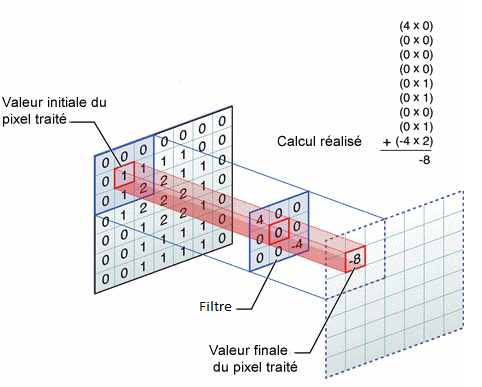

Le but du filtrage est de faire ressortir le maximum de caractéristiques d'une image, par exemple une detection de bord.

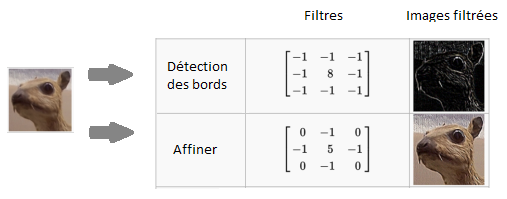

Le nombre de filtres determinera le nombre de caractéristiques détectées. Ce nombre est appelé la profondeur.

# Deuxième étape : Le Pooling

En prélevant les valeurs importantes des pixels, il permet de réduire une image tout en conservant ses caractéristiques. Elle consiste à réduire l'image en conservant les valeurs les plus grandes des pixels. 
Le pooling fonctionne comme pour un filtre, on a un carré qui se déplace sur la surface de l'image. 
À chaque position de ce carré, on prend la valeur la plus haute de chaque matrice. 
Cela produit une nouvelle image réduite avec uniquement les valeurs importantes de l'image. En réduisant l'image, le nombre de données traitées diminue et donc le temps de calcul sera lui aussi réduit.

 
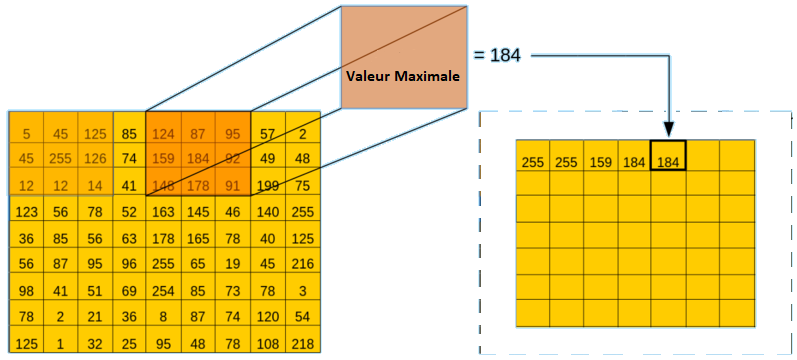



# Principe de la convolution

Le principe d'un réseau à convolution, c'est l'enchainement de ces deux fonctions. On applique des filtres puis on fait un Pooling sur le résulat de chaque filtre. Chaque étape est appellé un niveau. Un réseau à convolution peut avoir plusieurs niveaux.

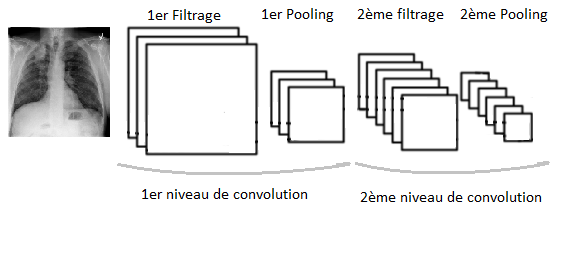

Cet exemple représente deux niveaux de convolution. A la suite de ces ceux-ci, six nouvelles images sont obtenues à partir de la première et représente chacune une caractéristique de l'image de base.

# Classification

A la fin des niveaux, les images obtenues sont injectés comme données d'entrée dans un réseau neuronal classique. Le but étant de classifier les données en déduisant une probabilité sur les différents résultats possibles. Par exemple la probabilité de voir un os ou du cartilage sur une radiographies.

 

Pour injecter les images dans le réseau neuronal, on applique un applatissement ("Flattening"). Cette opération permet de mettre à plat toutes les données dans un seul vecteur.

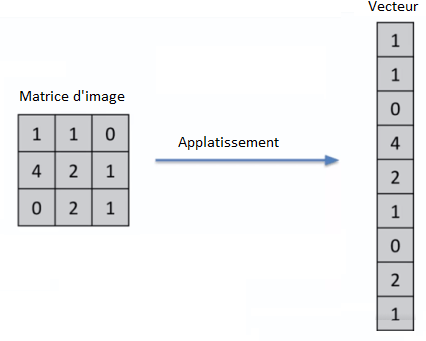

Ce vecteur permettra la création d'une première couche de neurones entièrement connectée.

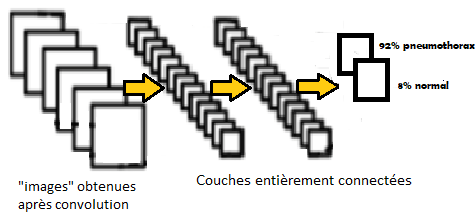

Voici un schéma global :

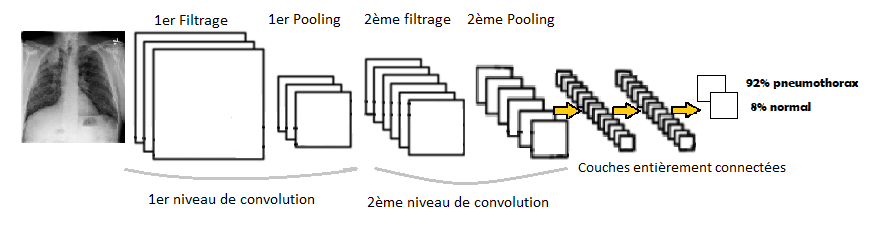

A la toute fin du réseau de convolution, on classe l'image là où la probabilité est la plus élevée.

Dans notre cas, il faut appliquer ce réseau de convolution à dicom-images-train pour entraîner le reseau neuronal (on pourra par la suite contrôler car nous connaissons les radiographies présentant un pneumothorax) dans le but d'augmenter les probabilités de chaque classe. Puis on applique le même réseau à dicom-images-test (pour lequel on ne connaît pas les pneumothorax). Par la suite, ce réseau va contrôler les similarités entre les images présentant un pneumothorax et ceux n'en présentant pas et les classer. On pourra alors, sans avoir vu les radiographies de tests, savoir si elle présente un pneumothorax ou non.

In [16]:
# Paramètres nécessaires
img_size = 512 # Pour redimensionner l'image
batch_size = 16 # Taille des échantillons pour l'Unet
k_size = 3 # Taille du noyau
val_size = .25 # split of training set between train and validation set
no_pneumo_drop = 0 # dropping some data to balance the class a little bit better

In [17]:
# On créer une classe de générateur de données pour charger progrssivement les données. Cela évite de mettre trop de données
# en mémoire
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_path_list, labels, batch_size=32, 
                 img_size=256, channels=1, shuffle=True):
        self.file_path_list = file_path_list
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.channels = channels
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        # Indique le nombre de lot à chaque période
        return int(np.floor(len(self.file_path_list)) / self.batch_size)
    
    def __getitem__(self, index):
        # Génère un lot de donnée
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Liste identifiant
        file_path_list_temp = [self.file_path_list[k] for k in indexes]
        # Génère les données
        X, y = self.__data_generation(file_path_list_temp)
        # Retourne les données
        return X, y
    
    def on_epoch_end(self):
        # Mise à jour après chaque période
        self.indexes = np.arange(len(self.file_path_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, file_path_list_temp):
        # Générer des données contenant les échantillons batch_size
        X = np.empty((self.batch_size, self.img_size, self.img_size, self.channels))
        y = np.empty((self.batch_size, self.img_size, self.img_size, self.channels))
        
        for idx, file_path in enumerate(file_path_list_temp):
            
            id = file_path.split('/')[-1][:-4]
            rle = self.labels.get(id)
            image = pydicom.read_file(file_path).pixel_array
            image_resized = cv2.resize(image, (self.img_size, self.img_size))
            image_resized = np.array(image_resized, dtype=np.float64)
            
            X[idx,] = np.expand_dims(image_resized, axis=2)
            
            # Si il n'y a pas de masques, créer un masque vide
            # On commence avec une taille de 1024 pour pouvoir utiliser la fonction rle2mask
            if rle is None:
                mask = np.zeros((1024, 1024))
            else:
                if len(rle) == 1:
                    mask = rle2mask(rle[0], 1024, 1024).T
                else: 
                    mask = np.zeros((1024, 1024))
                    for r in rle:
                        mask =  mask + rle2mask(r, 1024, 1024).T
                        
            mask_resized = cv2.resize(mask, (self.img_size, self.img_size))
            y[idx,] = np.expand_dims(mask_resized, axis=2)
            
        # On normalise 
        X = X / 255
        y = y / 255
            
        return X, y

In [18]:
masks = {}
for index, row in train_metadata_df[train_metadata_df['has_pneumothorax']==1].iterrows():
    masks[row['id']] = list(row['encoded_pixels_list'])

In [19]:
# Si une image ne présente pas de "EncodedPixels" alors on créer une nouvelle liste sans cette image
bad_data = train_metadata_df[train_metadata_df['encoded_pixels_count']==0].index
new_train_metadata_df = train_metadata_df.drop(bad_data)

In [20]:
drop_data = new_train_metadata_df[new_train_metadata_df['has_pneumothorax'] == False].sample(no_pneumo_drop).index
new_train_metadata_df = new_train_metadata_df.drop(drop_data)

In [21]:
# diviser les données de formation en train et ensemble de validation
X_train, X_val, y_train, y_val = train_test_split(new_train_metadata_df.index, new_train_metadata_df['has_pneumothorax'].values, test_size=val_size, random_state=42)
X_train, X_val = new_train_metadata_df.loc[X_train]['file_path'].values, new_train_metadata_df.loc[X_val]['file_path'].values

In [22]:
params = {'img_size': img_size,
          'batch_size': batch_size,
          'channels': 1,
          'shuffle': True}

# Generators
training_generator = DataGenerator(X_train, masks, **params)
validation_generator = DataGenerator(X_val, masks, **params)

In [23]:
# On peut maintenant coder le Unet qui consiste à la convolution des images

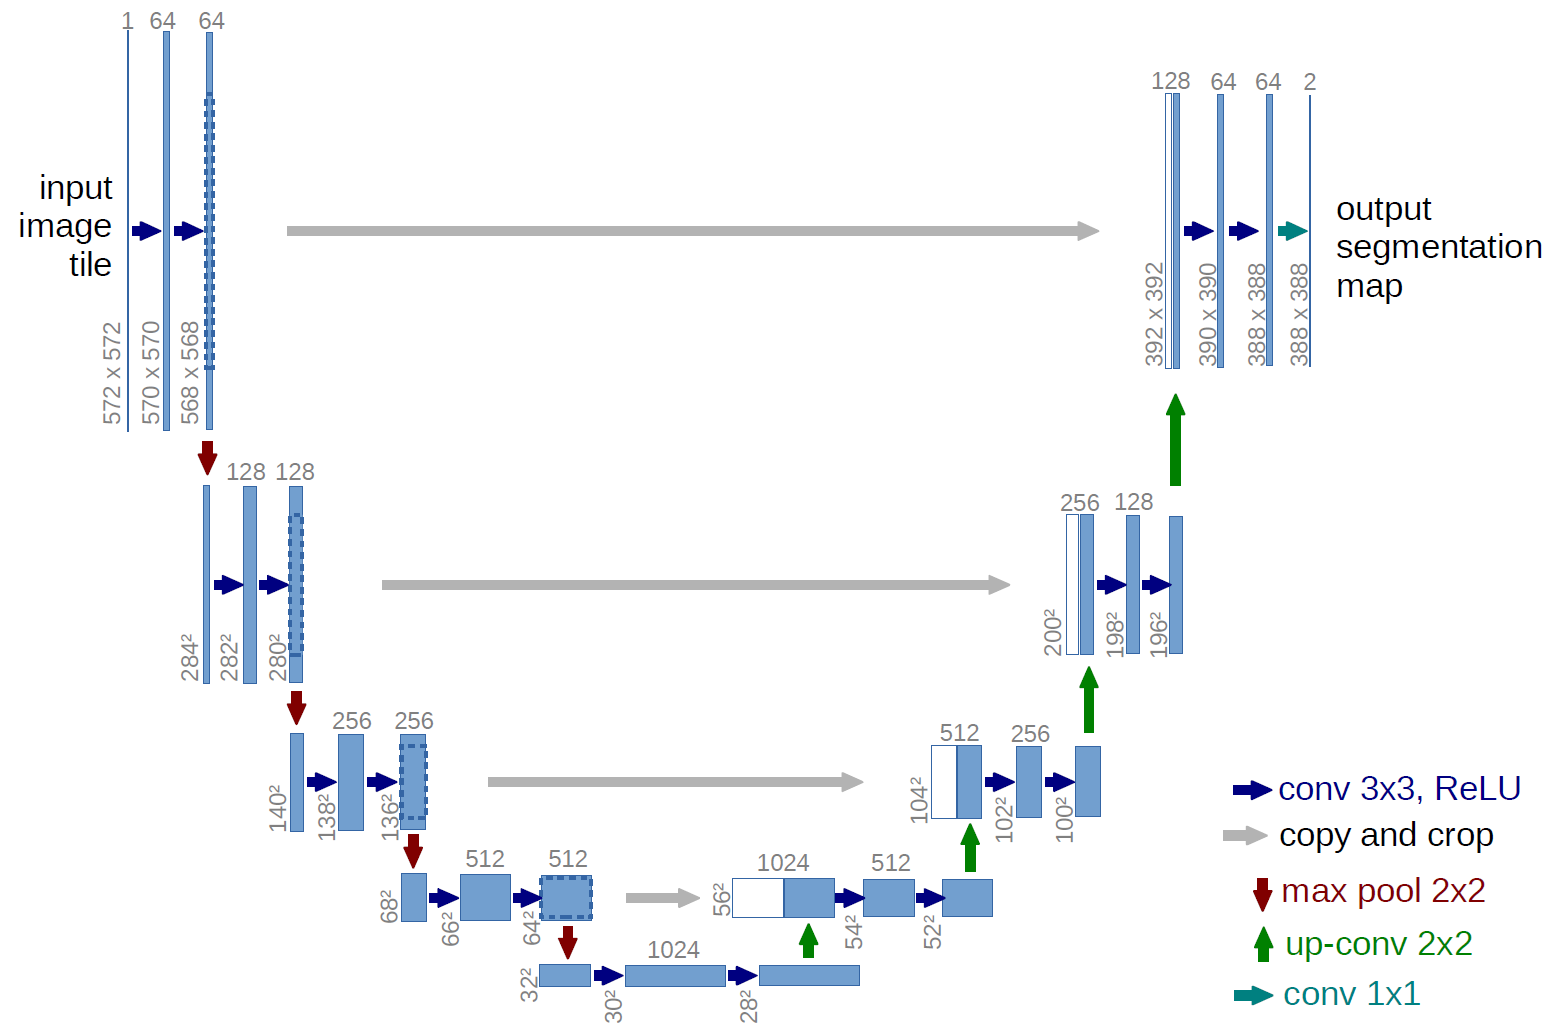

In [24]:
def down_block(x, filters, kernel_size=3, padding='same', strides=1, activation='relu'):
    # Cette définition permet la descente de l'Unet que l'on peut voir sur le schéma
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=activation)(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=activation)(conv)
    pool = MaxPool2D((2,2), (2,2))(conv)
    return conv, pool

In [25]:
def up_block(x, skip, filters, kernel_size=3, padding='same', strides=1, activation='relu'):
    # Cette définition permet la montée de l'Unet que l'on peut voir sur le schéma
    up_sample = UpSampling2D((2,2))(x)
    concat = Concatenate()([up_sample, skip])
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=activation)(concat)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=activation)(conv)
    return conv

In [26]:
def bottleneck(x, filters, kernel_size=3, padding='same', strides=1, activation='relu'):
    # Partie de l'Unet qui se situe entre la descente et la montée
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=activation)(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=activation)(conv)
    return conv

In [27]:
def UNet(img_size):
    # On construit l'Unet avec les définitions du dessus
    
    # Nombre de filtre par bloc
    f = [32,64,128,256,512]
    inputs = Input((img_size, img_size, 1))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0])
    c2, p2 = down_block(p1, f[1])
    c3, p3 = down_block(p2, f[2])
    c4, p4 = down_block(p3, f[3])
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3])
    u2 = up_block(u1, c3, f[2])
    u3 = up_block(u2, c2, f[1])
    u4 = up_block(u3, c1, f[0])
    
    outputs = Conv2D(1, (1,1), padding='same', activation='sigmoid')(u4)
    model = Model(inputs, outputs)
    return model

In [28]:
# Définition de la fonction loss et metrics

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [29]:
model = UNet(img_size)
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef])
model.summary() # Permet de voir la manière donc fonctionne notre Unet

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [30]:
# Dans la suite, nous faisons des prédictions en utilisant notre modèle Unet sur les radiographies tests
def get_test_tensor(file_path, batch_size, img_size, channels):
    
        X = np.empty((batch_size, img_size, img_size, channels))

        pixel_array = pydicom.read_file(file_path).pixel_array
        image_resized = cv2.resize(pixel_array, (img_size, img_size))
        image_resized = np.array(image_resized, dtype=np.float64)
        image_resized -= image_resized.mean()
        image_resized /= image_resized.std()
        X[0,] = np.expand_dims(image_resized, axis=2)

        return X

In [31]:
# Cette partie sert à générer un dictionnaire avec les prédictions pour les tests en mettant -1 dans 'EncodedPixels' 
# si un pneumothorax n'est pas présent
submission = []

for i, row in test_metadata_df.iterrows():

    test_img = get_test_tensor(test_metadata_df['file_path'][i],1,img_size,1)
    
    pred_mask = model.predict(test_img).reshape((img_size,img_size))
    prediction = {}
    prediction['ImageId'] = str(test_metadata_df['id'][i])
    pred_mask = (pred_mask > .5).astype(int)
    
    
    if pred_mask.sum() < 1:
        prediction['EncodedPixels'] =  -1
    else:
        prediction['EncodedPixels'] = mask2rle(pred_mask * 255, img_size, img_size)
    submission.append(prediction)

In [32]:
# Génère le fichier submission .csv pour référencer les pneumothorax. 
submission_df = pd.DataFrame(submission)
submission_df = submission_df[['ImageId','EncodedPixels']]
submission_df.head()

ImageId  \
0  1.2.276.0.7230010.3.1.4.8323329.5797.151787519...   
1  1.2.276.0.7230010.3.1.4.8323329.5798.151787519...   
2  1.2.276.0.7230010.3.1.4.8323329.5799.151787519...   
3  1.2.276.0.7230010.3.1.4.8323329.580.1517875163...   
4  1.2.276.0.7230010.3.1.4.8323329.5800.151787519...   

                                       EncodedPixels  
0  193 1 1 1 6 1 141 1 160 3 3 1 208 105 8 12 178...  
1  687 184 1 2 1 149 14 3 1 1 2 1 159 175 142 3 1...  
2  155 35 3 3 3 3 1 8 1 6 2 20 2 5 2 2 4 2 2 4 2 ...  
3  172 4 1 4 1 1 1 9 142 4 64 1 13 1 20 1 15 1 20...  
4  506 2 3 1 511 1 511 1 511 1 511 1 477 2 5 4 5 ...

In [33]:
# Enregistrement du fichier .csv avec les images dicom test avec annitation si un pneumothorax est présent. Si "EncodedPixels"
# = -1 alors il n'y a pas de pneumothorax
submission_df.to_csv('C:/Users/michael/Desktop/Challenge Image/submission.csv', index=False)